In [1]:
import tensorflow as tf
tf.enable_eager_execution()

# quick fix for imports
import sys
sys.path.append('..')


import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
from glob import glob
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D \
                                    ,Input, Lambda, MaxPooling2D, UpSampling2D\
                                    ,BatchNormalization, Lambda, LeakyReLU\
                                    , concatenate, Reshape
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import cv2
from imgaug import augmenters as iaa
from imgaug.augmentables import BoundingBox, BoundingBoxesOnImage
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from itertools import repeat
from collections import Counter
from mpl_toolkits.axes_grid1 import ImageGrid
import re
from scripts.constants import SEED
from pprint import pprint
import tensorflow_probability as tfp
import os
from google_drive_downloader import GoogleDriveDownloader as gdd
import copy

import ee
import folium

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [3]:
data_path = '../datasets/raw/bbox_data.gz'

In [4]:
class BoundBox:
    def __init__(self, xmin, xmax, ymin, ymax, c=None, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        self.c = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

    def __repr__(self):
        """
        Helper method for printing the object's values
        :return:
        """
        return "<BoundBox({}, {}, {}, {}, {}, {})>\n".format(
            self.xmin,
            self.xmax,
            self.ymin,
            self.ymax,
            self.get_label(),
            self.get_score()
        )

## UTILS functions

In [5]:

#needed in getitem
# no edits were made wrt to utils
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
    w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin

    union = w1 * h1 + w2 * h2 - intersect

    return float(intersect) / union

#needded in bbox_iou
# no edits were made wrt to utils

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2, x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2, x4) - x3
        
        
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)

    if np.min(x) < t:
        x = x / np.min(x) * t

    e_x = np.exp(x)

    return e_x / e_x.sum(axis, keepdims=True)

## augmentation and batch generator 
not really a batch generator, just described the layout for one image and bounding box, but it came from the batch generator file

In [6]:
# testing zone for augmentations

sometimes = lambda aug: iaa.Sometimes(0.5, aug)


#full aug pipe, with functions that dont scale to more dimensions
aug_pipe = iaa.Sequential(
            [
                # apply the following augmenters to most images
                iaa.Fliplr(0.5),  # horizontally flip 50% of all images
                iaa.Flipud(0.2),  # vertically flip 20% of all images
                # sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
                #sometimes(iaa.Affine(
                #    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # scale images to 80-120% of their size, per axis
                #    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # translate by -20 to +20 percent
                #    rotate=(-5, 5),  # rotate by -45 to +45 degrees
                #    shear=(-5, 5),  # shear by -16 to +16 degrees
                #    # order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                #    # cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                #    # mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                #))
            ],
            random_order=True
        )

In [7]:

def aug_image(image, objs, jitter=True):
    h = image.shape[0]
    w = image.shape[1]
    all_objs = copy.deepcopy(objs)
    if jitter:
        bbs = []
        for obj in all_objs:
            # see parse image for the correspondence between numeric index and values
            xmin = obj[0]
            xmax = obj[1] 
            ymin = obj[2]
            ymax = obj[3]            
            bbs.append(BoundingBox(x1=xmin, x2=xmax, y1=ymin, y2=ymax))           
            bbs = BoundingBoxesOnImage(bbs, shape=image.shape)
            image, bbs = aug_pipe(image=image, bounding_boxes=bbs)
            bbs = bbs.remove_out_of_image().clip_out_of_image()

            if len(all_objs) != 0:
                for i in range(len(bbs.bounding_boxes)):
                    all_objs[i][0] = bbs.bounding_boxes[i].x1 # xmin
                    all_objs[i][1] = bbs.bounding_boxes[i].x2 # xmax
                    all_objs[i][2] = bbs.bounding_boxes[i].y1 # ymin
                    all_objs[i][3] = bbs.bounding_boxes[i].y2 # ymax
    
    # resize the image to standard size
    image = cv2.resize(image, (257, 257)) # 257, 257: self._config['IMAGE_W'], self._config['IMAGE_H']
    '''
    if self._config['IMAGE_C'] == 1: #self._config['IMAGE_C']
        image = image[..., np.newaxis]
    '''    
    #image = image[..., ::-1]  
    
    # fix object's position and size
    for obj in all_objs:
        for attr in [0, 1]: #xmin, xmax
            obj[attr] = int(obj[attr] * float(257) / w) # 257: self._config['IMAGE_W']
            obj[attr] = max(min(obj[attr], 257), 0) # 257: self._config['IMAGE_W']

        for attr in [2, 3]: #ymin, ymax
            obj[attr] = int(obj[attr] * float(257) / h) # 257: self._config['IMAGE_H']
            obj[attr] = max(min(obj[attr], 257), 0) # 257: self._config['IMAGE_H']
    return image, all_objs

In [8]:
def getBatch(img, objs, anchor_pos, jitter=True):
    # rewrite everything from batch level to single example
    
    # mostly redundant code
    '''
    l_bound = idx * self._config['BATCH_SIZE']
    r_bound = (idx + 1) * self._config['BATCH_SIZE']

    if r_bound > len(self._images):
        r_bound = len(self._images)
        l_bound = r_bound - self._config['BATCH_SIZE']

    instance_count = 0
    if self._config['IMAGE_C'] == 3:
        x_batch = np.zeros((r_bound - l_bound, self._config['IMAGE_H'], self._config['IMAGE_W'], 3))  # input images
    else:
        x_batch = np.zeros((r_bound - l_bound, self._config['IMAGE_H'], self._config['IMAGE_W'], 1))

    y_batch = np.zeros((r_bound - l_bound, self._config['GRID_H'], self._config['GRID_W'], self._config['BOX'],
                        4 + 1 + len(self._config['LABELS'])))  # desired network output
                        
    '''
    
    #height width, channels from the image
    h, w, c = img.shape
    all_anchors = [BoundBox(0, anchor_pos[2 * i], 0,  anchor_pos[2 * i + 1])
                   for i in range(int(len(anchor_pos) // 2))]   
    BOX = len(anchor_pos) // 2
    LABELS = 1 #SHOULD BE LEN(CONFIG['LABELS'])
    # self.config['image width'], also height, and second line grid sizes for heigh and width , respect
    x_batch = np.zeros((257, 257, c))  # input images
    y_batch = np.zeros((8, 8, BOX, 4 + 1 + 1)) # desired network output
    #  config['ANCHORS'][2 * i], config['ANCHORS'][2 * i + 1])
    


    
    # augment input image and fix object's position and size
    img, all_objs = aug_image(img, objs, jitter= jitter)
    # this is a valid for loop (belongs to a single example)
    for obj in all_objs:
        # Translation list (dictionaries are not a good combo with tensorflow): 
        # 0: xmin 
        # 1: xmax
        # 2: ymin 
        # 3: ymax

        # xmax > xmin and ymax > ymin and name and obj['name'] in self._config['LABELS']: (fix this later!!!)
        #interpretation: actual location of x and y wrt grid cell:
        # center = 127 pixels, grid =8, width = 256, then center is at 127 / 32 ~= 3rd grid cell in x direction
        if obj[1] > obj[0] and obj[3] > obj[2]: # and obj['name'] in self._config['LABELS']:
            center_x = .5 * (obj[0] + obj[1])
            center_x = center_x / (float(257) / 8) #self._config['IMAGE_W'], self._config['GRID_W'] 
            center_y = .5 * (obj[2] + obj[3])
            center_y = center_y / (float(257) / 8) #self._config['IMAGE_H'], self._config['GRID_H']

            grid_x = int(np.floor(center_x))
            grid_y = int(np.floor(center_y))

            # if grid_x < self._config['GRID_W'] and grid_y < self._config['GRID_H']:
            if grid_x < 8 and grid_y < 8:
                # Alter the below variable later, not relevant yet
                # obj_indx = self._config['LABELS'].index(obj['name'])
                obj_indx = 0

                # center relative to grid cell pixels:
                # if center is 10 pixels and grid cell is 32 pixels: center_w=5/16, "width is 5/16th of grid cell" 
                center_w = (obj[1] - obj[0]) / (
                            float(257) / 8) #self._config['IMAGE_W'], self._config['GRID_W']
                center_h = (obj[3] - obj[2]) / (
                            float(257) / 8)

                box = [center_x, center_y, center_w, center_h]

                # find the anchor that best predicts this box
                # i.e.: the best anchor shape that fits the box
                best_anchor = -1
                max_iou = -1


                shifted_box = BoundBox(0, center_w, 0, center_h)

                # fit anchors, which "shape" out of all anchors fits the current bbox best?
                for i in range(len(all_anchors)):
                    anchor = all_anchors[i]
                    iou = bbox_iou(shifted_box, anchor)

                    if max_iou < iou:
                        best_anchor = i
                        max_iou = iou

                # assign ground truth x, y, w, h, confidence and class probs to y_batch
                y_batch[grid_y, grid_x, best_anchor, 0:4] = box
                y_batch[grid_y, grid_x, best_anchor, 4] = 1.
                y_batch[grid_y, grid_x, best_anchor, 5 + obj_indx] = 1

    # assign input image to x_batch
    norm = 1
    if norm is not None:
        x_batch = img
    # deal with this later? or done earlier in tfrecord procedure
    #if self._norm is not None:
    #   x_batch[instance_count] = self._norm(img)
    else:
        # plot image and bounding boxes for sanity check
        for obj in all_objs:
            if obj[1] > obj[0] and obj[3] > obj[2]:
                cv2.rectangle(img[..., 0:3], (obj[0], obj[2]), (obj[1], obj[3]),
                              (255, 0, 0), 3)
                cv2.putText(img[..., ::-1], 'DAM', (obj[0] + 2, obj[2] + 12), 0,
                            1.2e-3 * img.shape[0], (0, 255, 0), 2)

        x_batch[instance_count] = img

    
    return x_batch, y_batch.astype(np.float32)

In [9]:


def parse_serialized_example(example_proto):
    ''' Parser function
    Useful for functional extraction, i.e. .map functions
    
    Args:
        example_proto: a serialized example
        
    Returns:
        A dictionary with features, cast to float32
        This returns a dictionary of keys and tensors to which I apply the transformations.
    '''
    # feature columns of interest
    featuresDict = {
        'B2': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # B
        'B3': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # G
        'B4': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # R
        #'AVE': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # Elevation
        'NDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'MNDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'AWEINSH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'AWEISH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        #'index': tf.io.FixedLenFeature([1], dtype=tf.int64), # index
        'PIXEL_LABEL': tf.io.FixedLenFeature([257, 257], dtype=tf.float32) #label
    }
    
    return tf.io.parse_single_example(example_proto, featuresDict)
    


def stretch_image_colorspace(img):
    max_val = tf.reduce_max(img)
    return tf.cast(tf.divide(img, max_val), tf.float32)

def stretch_image_colorspace_uint8(img):
    max_val = tf.reduce_max(img)
    return tf.cast(tf.multiply(tf.divide(img, max_val), 255), tf.uint8)

#using a closure so we can add extra params to the map function from tf.Dataset
def parse_image(dims = [257, 257], channels = ['B4', 'B3', 'B2'], stretch_colorspace=True):
    ''' Stack individual RGB bands into a N dimensional array
    The RGB bands are still separate 1D arrays in the TFRecords, combine them into a single 3D array
    
    Args:
        features: A dictionary with the features (RGB bands or other channels that need to be concatenated)
    '''
    
    # print("using the general image parsing function")
    def parse_image_fun(features):
        #channels = list(features.values())
        
        label = tf.cast(features['PIXEL_LABEL'], tf.int32)
        def get_corner_values(label):
            condition = tf.equal(label,tf.constant(1))
            locs = tf.where(condition)
            return locs[0][0], locs[0][1], locs[-1][0], locs[-1][1]
        xmin, ymax, xmax, ymin = get_corner_values(label)

        
        # Get the image channels, and NDWI/AVE channels separately
        # we cannot import them all at once since they need separate preprocessing steps
        img_chan = [features[x] for x in channels if x in ['B4', 'B3', 'B2']]
        ndwi_chan = [features[x] for x in channels if x in ['NDWI']]
        mndwi_chan = [features[x] for x in channels if x in ['MNDWI']]
        aweinsh_chan = [features[x] for x in channels if x in ['AWEINSH']]
        aweish_chan = [features[x] for x in channels if x in ['AWEISH']]
        ave_chan = [features[x] for x in channels if x in ['AVE']]
        
        # CHANGE TO CONFIG
        anchors = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

        
        # stack the individual arrays, remove all redundant dimensions of size 1, and transpose them into the right order
        # (batch size, H, W, channels)
        img = tf.transpose(tf.squeeze(tf.stack(img_chan)))
        
        # stretch color spaces of the RGB channels
        if stretch_colorspace:
            img = stretch_image_colorspace(img)
        
        '''
        if ndwi_chan:
            # further normalization?
            img = tf.concat([img, tf.transpose(ndwi_chan)], axis= 2)
        
        if mndwi_chan:
            img = tf.concat([img, tf.transpose(mndwi_chan)], axis= 2)
            
        if aweinsh_chan:
            img = tf.concat([img, tf.transpose(aweinsh_chan)], axis= 2)
            
        if aweish_chan:
            img = tf.concat([img, tf.transpose(aweish_chan)], axis= 2)
        
        if ave_chan:
            # normalization: https://developers.google.com/earth-engine/datasets/catalog/JAXA_ALOS_AW3D30_V1_1
            ave_chan = tf.divide(tf.add(ave_chan, 479) ,479 + 8859)
            img = tf.concat([img, tf.transpose(ave_chan)], axis= 2)
        
        '''
        
        # TENSORFLOW DOES NOT LIKE DICTIONARIES, KEEP TRACK OF THE ORDER!!!
        obj = [xmin, xmax, ymin, ymax]
        # possibly redundant, but now for safe keeping, (attempt at deepcopying the variable)
        orig_obj = tf.identity(obj)
        
        image, all_objs = tf.numpy_function(aug_image,
                                            [img, [obj], True],
                                            [tf.float32, tf.int64])
        
        # not actually a batch, just a single image
        x_batch, y_batch = tf.numpy_function(getBatch,
                                            [img, [obj],anchors, True],
                                            [tf.float32, tf.float32])
        
        # Additionally, resize the images to a desired size
        #do not use this anymore with object detection!
        #img = tf.image.resize(img, dims)
        return x_batch, y_batch
    
    return parse_image_fun

In [10]:
train_data = tf.data.TFRecordDataset(data_path, compression_type='GZIP')
dataset = train_data.map(parse_serialized_example)

for x in dataset.take(1):
    print("dataset before normalization and pre processing")
    #print(x)

    print("done showing serializing")
    
    
parsed_image = dataset.map(parse_image([257, 257], 
                        stretch_colorspace = True, 
                        channels = ['B4', 'B3', 'B2', 'NDWI']))

for x_batch, y_batch in parsed_image.take(1):
    print("x batch size is", x_batch.shape)
    print("x batch is", x_batch)
    print("y batch shape is", y_batch.shape)
    print("max val y batch", np.max(y_batch.numpy()))

    

dataset before normalization and pre processing
done showing serializing
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
x batch size is (257, 257, 3)
x batch is tf.Tensor(
[[[0.27911392 0.44303796 0.51455694]
  [0.26329112 0.42088607 0.5006329 ]
  [0.2518987  0.40949365 0.48734176]
  ...
  [0.47753164 0.63892406 0.6234177 ]
  [0.45253164 0.64367086 0.610443  ]
  [0.43449366 0.61930376 0.5993671 ]]

 [[0.27468354 0.4329114  0.50759494]
  [0.27151898 0.4398734  0.5006329 ]
  [0.26139238 0.4164557  0.49873415]
  ...
  [0.4800633  0.64841765 0.61962026]
  [0.43734175 0.6357595  0.603481  ]
  [0.38449365 0.5955696  0.58797467]]

 [[0.25949368 0.39683545 0.49620253]
  [0.26392406 0.4063291  0.49113923]
  [0.26962024 0.41835442 0.50443035]
  ...
  [0.47436708 0.6509493  0.62025315]
  [0.47658226 0.6357595  0.61613923]
  [0.44778478 0.60063285 0.6094936 ]]

 ...

 [[0.26107594 0.45664555 0.5088607 ]
  [0.26455694 0.44715187 0.50727844]
  [0.262974

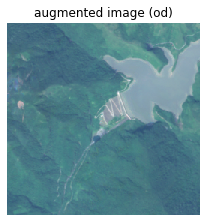

In [17]:
# ADD AVE/NDWI heatmaps?
columns = 3
rows = 1

fig = plt.figure(figsize=(columns+8, rows+5))
gs = gridspec.GridSpec(rows, columns,
         wspace=0.2, hspace=0.4, 
         top=1.2-0.5/(rows + 1), bottom=0.5/(rows+1), 
         left=0.5/(columns+1), right=1-0.2/(columns+1)) 

parse_iter = iter(parsed_image)

for j in range(rows):
    image_features, y_batch = parse_iter.next()
    label = 0
    #good example: stretched colorspace
    #uint8 only stores 256 values :/
    ax = plt.subplot(gs[j,0])
    ax.set_title("augmented image (od)".format(np.argmax(label)))
    ax.imshow(image_features[:,:,0:3])
    plt.axis('off')

    
    '''
    ax = plt.subplot(gs[j,1])
    ax.set_title("NDWI".format(np.argmax(label.numpy())))
    im = ax.imshow(image_features[:,:,3], cmap='viridis', interpolation='nearest')
    #fig.colorbar(im,ax=ax)
    plt.axis('off')
    
    ax = plt.subplot(gs[j,2])
    ax.set_title("MNDWI, label: {}".format(np.argmax(label.numpy())))
    im =ax.imshow(image_features[:,:,4], cmap='viridis', interpolation='nearest')
    #fig.colorbar(im,ax=ax)
    plt.axis('off')
    
    ax = plt.subplot(gs[j,3])
    ax.set_title("AWEINSH, label: {}".format(np.argmax(label.numpy())))
    im =ax.imshow(image_features[:,:,5], cmap='viridis', interpolation='nearest')
    #fig.colorbar(im,ax=ax)
    plt.axis('off')
    
    ax = plt.subplot(gs[j,4])
    ax.set_title("AWEISH, label: {}".format(np.argmax(label.numpy())))
    im =ax.imshow(image_features[:,:,6], cmap='viridis', interpolation='nearest')
    #fig.colorbar(im,ax=ax)
    plt.axis('off')
    
    ax = plt.subplot(gs[j,5])
    ax.set_title("Elevation".format(np.argmax(label.numpy())))
    im =ax.imshow(image_features[:,:,7], cmap='viridis', interpolation='nearest')
    #fig.colorbar(im,ax=ax)
    plt.axis('off')
    
    print(label.shape)
    ax = plt.subplot(gs[j,6])
    ax.set_title("Elevation".format(np.argmax(label.numpy())))
    im =ax.imshow(label, cmap='viridis', interpolation='nearest')
    #fig.colorbar(im,ax=ax)
    plt.axis('off')
    '''


In [18]:
#ismi notebook
def get_matplotlib_boxes_2(boxes, img_shape):
    plt_boxes = []
    for box in boxes:
        xmin  = int(box.xmin * img_shape[1])
        xmax  = int(box.xmax * img_shape[1])
        ymin  = int(box.ymin * img_shape[0])
        ymax  = int(box.ymax * img_shape[0]) 
        print(xmin, xmax, ymin, ymax)
        plt_boxes.append(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='#00FF00', linewidth='2'))
    return plt_boxes

# my own
def get_matplotlib_boxes(boxes, img_shape):
    plt_boxes = []
    for box in boxes:
        plt_boxes.append(patches.Rectangle((box.xmin, box.ymin), box.xmax-box.xmin, box.ymax-box.ymin, fill=False, color='#00FF00', linewidth='2'))
    return plt_boxes

'''
# an edit
def get_matplotlib_boxes(boxes, img_shape):
    plt_boxes = []
    width = 257
    height = 257
    for box in boxes:
        x = (box.xmin + box.xmax) / 2 / width
        y = (box.ymin + box.ymax) / 2 / height
        # difference between max and min, normalized by width
        w = (box.xmax - box.xmin) / width
        h = (box.ymax - box.ymin) / width
        xmin  = int((x - w/2) * img_shape[1])
        xmax  = int((x + w/2) * img_shape[1])
        ymin  = int((y - h/2) * img_shape[0])
        ymax  = int((y + h/2) * img_shape[0])        
        plt_boxes.append(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='#00FF00', linewidth='2'))
    return plt_boxes
'''

"\n# an edit\ndef get_matplotlib_boxes(boxes, img_shape):\n    plt_boxes = []\n    width = 257\n    height = 257\n    for box in boxes:\n        x = (box.xmin + box.xmax) / 2 / width\n        y = (box.ymin + box.ymax) / 2 / height\n        # difference between max and min, normalized by width\n        w = (box.xmax - box.xmin) / width\n        h = (box.ymax - box.ymin) / width\n        xmin  = int((x - w/2) * img_shape[1])\n        xmax  = int((x + w/2) * img_shape[1])\n        ymin  = int((y - h/2) * img_shape[0])\n        ymax  = int((y + h/2) * img_shape[0])        \n        plt_boxes.append(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='#00FF00', linewidth='2'))\n    return plt_boxes\n"

image shape in the aug image fun is:  (257, 257, 4)
image shape in the aug image fun is:  (257, 257, 4)
tf.Tensor([[ 36 157  59 171]], shape=(1, 4), dtype=int64)
tf.Tensor([ 73 183 185  72], shape=(4,), dtype=int64)


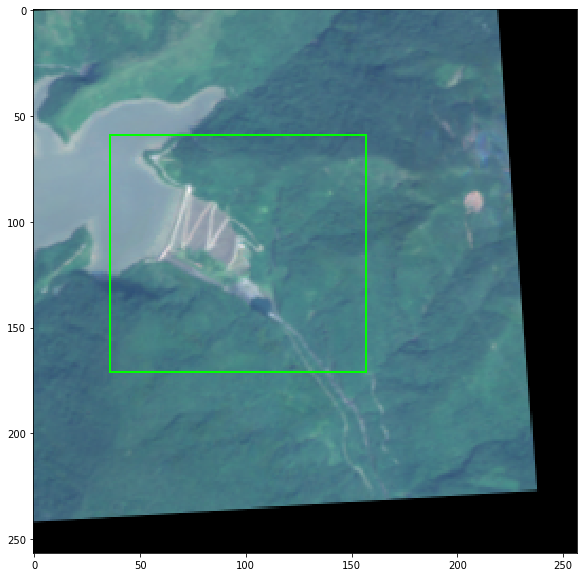

In [272]:
for _,_,image_features, img, all_objs, orig_obj, label in parsed_image.take(1):
    print(all_objs)
    print(orig_obj)
    all_objs = all_objs[0]
    bbox = BoundBox(all_objs.numpy()[0], all_objs.numpy()[1], all_objs.numpy()[2], all_objs.numpy()[3] )


# get bounding boxes in matplotlib format
plt_boxes = get_matplotlib_boxes([bbox],image_features.numpy().shape)
# visualize image and bounding box
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(image_features.numpy()[:,:,0:3].squeeze(), cmap='gray')
for plt_box in plt_boxes:
    ax.add_patch(plt_box)
plt.show()

In [90]:
dummy_array = np.zeros((1,1,1,1,50,4))
print(dummy_array.shape)

(1, 1, 1, 1, 50, 4)


## YOLO model and other goodness...

In [19]:
# set the parameters for the detection of the right lung

LABELS = ['RL']

IMAGE_H, IMAGE_W = 257, 257
GRID_H,  GRID_W  = 8 , 8
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0 # lambda noobj
OBJECT_SCALE     = 5.0 # lambda obj
COORD_SCALE      = 1.0 # don't touch this
CLASS_SCALE      = 1.0 # don't touch this

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 100
TRUE_BOX_BUFFER  = 50

In [20]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [22]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

In [23]:
def YOLO_network(input_img, CLASS):

    # Layer 1
    x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_img)
    x = BatchNormalization(name='norm_1')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 2
    x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 3
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
    x = BatchNormalization(name='norm_3')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 4
    x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
    x = BatchNormalization(name='norm_4')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 5
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
    x = BatchNormalization(name='norm_5')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 6
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
    x = BatchNormalization(name='norm_6')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 7
    x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
    x = BatchNormalization(name='norm_7')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 8
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False, input_shape=(512,512,3))(x)
    x = BatchNormalization(name='norm_8')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 9
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
    x = BatchNormalization(name='norm_9')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 10
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
    x = BatchNormalization(name='norm_10')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 11
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
    x = BatchNormalization(name='norm_11')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 12
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
    x = BatchNormalization(name='norm_12')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 13
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
    x = BatchNormalization(name='norm_13')(x)
    x = LeakyReLU(alpha=0.1)(x)

    skip_connection = x

    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 14
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
    x = BatchNormalization(name='norm_14')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 15
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
    x = BatchNormalization(name='norm_15')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 16
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
    x = BatchNormalization(name='norm_16')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 17
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
    x = BatchNormalization(name='norm_17')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 18
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
    x = BatchNormalization(name='norm_18')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 19
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
    x = BatchNormalization(name='norm_19')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 20
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
    x = BatchNormalization(name='norm_20')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 21
    skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
    skip_connection = BatchNormalization(name='norm_21')(skip_connection)
    skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
    skip_connection = Lambda(space_to_depth_x2)(skip_connection)

    x = concatenate([skip_connection, x])

    # Layer 22
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
    x = BatchNormalization(name='norm_22')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 23
    #x = Conv2D(BOX * (4 + 1 + CLASS), 
    #                 (1,1), strides=(1,1), 
    #                 padding='same', 
    #                 name='conv_23')(x)
    #output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

    output = Conv2D(BOX * (4 + 1 + CLASS),
                        (1, 1), strides=(1, 1),
                        padding='same',
                        name='Detection_layer',
                        kernel_initializer='lecun_normal')(x)
    output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS), name="YOLO_output")(output)
    
    # small hack to allow true_boxes to be registered when Keras build the model 
    # for more information: https://github.com/fchollet/keras/issues/2790
    #output = Lambda(lambda args: args[0])([output, true_bxs])

    model = Model(input_img, output)
    
    model.summary()
    
    return model

In [64]:
model = YOLO_network(input_image, CLASS)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 257, 257, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 257, 257, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 257, 257, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_154 (LeakyReLU)     (None, 257, 257, 32) 0           norm_1[0][0]                     
____________________________________________________________________________________________

In [18]:
# define variable needed to process input image
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
# get output from network
netout = model.predict(image_features[np.newaxis,:,:,0:3])

NameError: name 'image_features' is not defined

In [26]:
print(netout.shape)
print(netout[0,1,1,1])

NameError: name 'netout' is not defined

In [54]:
def decode_netout(netout, anchors, nb_class, obj_threshold=0.5, nms_threshold=0.3):
    grid_h, grid_w, nb_box = netout.shape[:3]
    boxes = []

    # decode the output by the network
    netout[..., 4] = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > float(obj_threshold)

    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row, col, b, 5:]

                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row, col, b, :4]

                    x = (col + _sigmoid(x)) / grid_w  # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h  # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w  # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h  # unit: image height
                    confidence = netout[row, col, b, 4]
                    box = BoundBox(x - w / 2, x + w / 2, y - h / 2, y + h / 2, confidence, classes)

                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0:
                continue
            else:
                for j in range(i + 1, len(sorted_indices)):
                    index_j = sorted_indices[j]

                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_i].classes[c] = 0

    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    return boxes

In [55]:
# from the notebook, edited for TFRecords

def predict_bounding_box(img, model, obj_threshold, nms_threshold, anchors, nb_class):
    """
        Predict bounding boxes for a given image.
    """    
    
    # define variable needed to process input image
    dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

    # get output from network
    netout = model.predict(img)
    print(netout.shape)
    return decode_netout(netout[0], anchors, nb_class, obj_threshold, nms_threshold ) 

## Plotting result

(1, 8, 8, 5, 6)
-14 46 -17 49
-140 172 -131 163
82 142 -17 49
50 303 -40 72
210 271 -17 49
82 335 55 169
-14 46 111 177
-37 69 120 296
-14 46 207 274
114 174 207 274
51 365 93 388
210 271 207 274
12


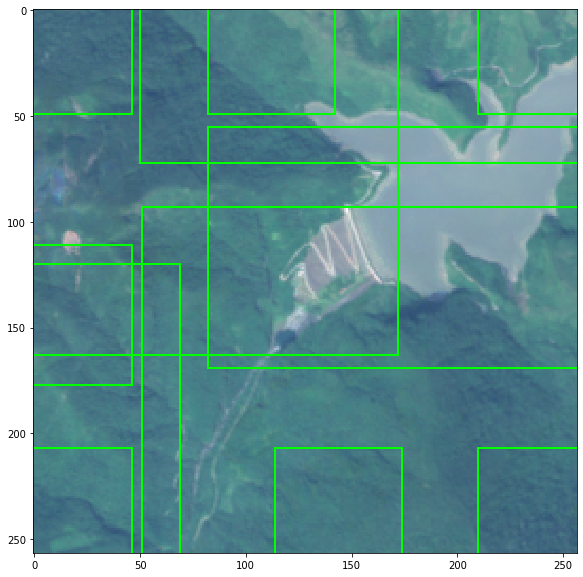

In [56]:
# define a threshold to apply to predictions
obj_threshold=0.5
boxes = predict_bounding_box(image_features[np.newaxis,...,0:3], model, obj_threshold, NMS_THRESHOLD, ANCHORS, CLASS)

# batch dimensions is removed, since we do not need it in get_matplotlib_boxes_2
img_shape = image_features[...,0:3].numpy().shape
# get matplotlib bbox objects
plt_boxes = get_matplotlib_boxes_2(boxes, img_shape)

# visualize result
# in an untrainedd network, all the boxes are in the upper left corner and are very small
# this can be expected, as the results are just bad...

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(image_features[...,0:3])
print(len(plt_boxes))
for plt_box in plt_boxes:
    ax.add_patch(plt_box)
plt.show()


## YOLO loss

In [71]:
EPSILON = 1e-7


def calculate_ious(a1, a2, use_iou=True):

    if not use_iou:
        return a1[..., 4]

    def process_boxes(a):
        # ALign x-w, y-h
        a_xy = a[..., 0:2]
        a_wh = a[..., 2:4]
        
        a_wh_half = a_wh / 2.
        # Get x_min, y_min
        a_mins = a_xy - a_wh_half
        # Get x_max, y_max
        a_maxes = a_xy + a_wh_half
        
        return a_mins, a_maxes, a_wh
    
    # Process two sets
    a2_mins, a2_maxes, a2_wh = process_boxes(a2)
    a1_mins, a1_maxes, a1_wh = process_boxes(a1)

    # Intersection as min(Upper1, Upper2) - max(Lower1, Lower2)
    intersect_mins = K.maximum(a2_mins,  a1_mins)
    intersect_maxes = K.minimum(a2_maxes, a1_maxes)
    
    # Getting the intersections in the xy (aka the width, height intersection)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)

    # Multiply to get intersecting area
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # Values for the single sets
    true_areas = a1_wh[..., 0] * a1_wh[..., 1]
    pred_areas = a2_wh[..., 0] * a2_wh[..., 1]

    # Compute union for the IoU
    union_areas = pred_areas + true_areas - intersect_areas
    return intersect_areas / union_areas


class YoloLoss(object):

    def __init__(self, anchors, grid_size, batch_size, lambda_coord=5, lambda_noobj=1, lambda_obj=1, lambda_class=1,
                 iou_filter=0.6):

        self.__name__ = 'yolo_loss'
        self.iou_filter = iou_filter
        self.readjust_obj_score = False

        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.lambda_obj = lambda_obj
        self.lambda_class = lambda_class

        self.batch_size = batch_size
        self.grid_size = grid_size
        self.nb_anchors = len(anchors)//2
        self.anchors = np.reshape(anchors, [1, 1, 1, self.nb_anchors, 2])

        self.c_grid = self._generate_yolo_grid(self.batch_size, self.grid_size, self.nb_anchors)

    @staticmethod
    def _generate_yolo_grid(batch_size, grid_size, nb_box):
        cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(grid_size[0]), [grid_size[1]]), (1, grid_size[1], grid_size[0],
                                                                                          1, 1)))
        cell_y = tf.to_float(tf.reshape(tf.tile(tf.range(grid_size[1]), [grid_size[0]]), (1, grid_size[0], grid_size[1],
                                                                                          1, 1)))
        cell_y = tf.transpose(cell_y, (0, 2, 1, 3, 4))
 
        cell_grid = tf.tile(tf.concat([cell_x, cell_y], -1), [batch_size, 1, 1, nb_box, 1])
        return cell_grid

    def _transform_netout(self, y_pred_raw):
        y_pred_xy = K.sigmoid(y_pred_raw[..., :2]) + self.c_grid
        y_pred_wh = K.exp(y_pred_raw[..., 2:4]) * self.anchors
        y_pred_conf = K.sigmoid(y_pred_raw[..., 4:5])
        y_pred_class = y_pred_raw[..., 5:]

        return K.concatenate([y_pred_xy, y_pred_wh, y_pred_conf, y_pred_class], axis=-1)

    def coord_loss(self, y_true, y_pred):
        
        b_xy_pred = y_pred[..., :2]
        b_wh_pred = y_pred[..., 2:4]
        
        b_xy = y_true[..., 0:2]
        b_wh = y_true[..., 2:4]

        indicator_coord = K.expand_dims(y_true[..., 4], axis=-1) * self.lambda_coord

        loss_xy = K.sum(K.square(b_xy - b_xy_pred) * indicator_coord)
        loss_wh = K.sum(K.square(b_wh - b_wh_pred) * indicator_coord)
        # loss_wh = K.sum(K.square(K.sqrt(b_wh) - K.sqrt(b_wh_pred)) * indicator_coord)#, axis=[1,2,3,4])

        return (loss_wh + loss_xy) / 2

    def obj_loss(self, y_true, y_pred):

        b_o = calculate_ious(y_true, y_pred, use_iou=self.readjust_obj_score)
        b_o_pred = y_pred[..., 4]

        num_true_labels = self.grid_size[0] * self.grid_size[1] * self.nb_anchors
        y_true_p = K.reshape(y_true[..., :4], shape=(self.batch_size, 1, 1, 1, num_true_labels, 4))
        iou_scores_buff = calculate_ious(y_true_p, K.expand_dims(y_pred, axis=4))
        best_ious = K.max(iou_scores_buff, axis=4)

        indicator_noobj = K.cast(best_ious < self.iou_filter, np.float32) * (1 - y_true[..., 4]) * self.lambda_noobj
        indicator_obj = y_true[..., 4] * self.lambda_obj
        indicator_o = indicator_obj + indicator_noobj

        loss_obj = K.sum(K.square(b_o-b_o_pred) * indicator_o)
        return loss_obj / 2

    def class_loss(self, y_true, y_pred):

        p_c_pred = K.softmax(y_pred[..., 5:])
        p_c = K.one_hot(K.argmax(y_true[..., 5:], axis=-1), 1)
        loss_class_arg = K.sum(K.square(p_c - p_c_pred), axis=-1)
        
        # b_class = K.argmax(y_true[..., 5:], axis=-1)
        # b_class_pred = y_pred[..., 5:]
        # loss_class_arg = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=b_class, logits=b_class_pred)

        indicator_class = y_true[..., 4] * self.lambda_class

        loss_class = K.sum(loss_class_arg * indicator_class)

        return loss_class

    def l_coord(self, y_true, y_pred_raw):
        return self.coord_loss(y_true, self._transform_netout(y_pred_raw))

    def l_obj(self, y_true, y_pred_raw):
        return self.obj_loss(y_true, self._transform_netout(y_pred_raw))

    def l_class(self, y_true, y_pred_raw):
        return self.class_loss(y_true, self._transform_netout(y_pred_raw))

    def __call__(self, y_true, y_pred_raw):

        y_pred = self._transform_netout(y_pred_raw)

        total_coord_loss = self.coord_loss(y_true, y_pred)
        total_obj_loss = self.obj_loss(y_true, y_pred)
        total_class_loss = self.class_loss(y_true, y_pred)

        loss =  total_coord_loss + total_obj_loss + total_class_loss

        return loss #, total_coord_loss, total_obj_loss, total_class_loss


In [72]:
batch_size = 11
# set the parameters for the detection of the right lung

LABELS = ['RL']

IMAGE_H, IMAGE_W = 257, 257
GRID_H,  GRID_W  = 8 , 8
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0 # lambda noobj
OBJECT_SCALE     = 5.0 # lambda obj
COORD_SCALE      = 1.0 # don't touch this
CLASS_SCALE      = 1.0 # don't touch this

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 100
TRUE_BOX_BUFFER  = 50


yolo_loss = YoloLoss(ANCHORS, (8, 8), batch_size,
                             lambda_coord=COORD_SCALE, lambda_noobj=NO_OBJECT_SCALE, lambda_obj=OBJECT_SCALE,
                             lambda_class=CLASS_SCALE)



TARGET_SIZE= [257, 257]
BUFFER_SIZE= 30
CHANNELS = ['B4', 'B3', 'B2']
STRETCH_COLORSPACE=True
BATCH_SIZE = batch_size



In [73]:
def random(file_names, batch_size, target_size, buffer_size, channels, stretch_colorspace=True):
    dataset = tf.data.TFRecordDataset(file_names, compression_type='GZIP')
    #dataset = dataset.repeat(4)
    dataset = dataset.map(parse_serialized_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(parse_image(dims = target_size, channels = channels, stretch_colorspace=stretch_colorspace), 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #dataset = dataset.shuffle(10)
    # yolo class loss has fixed batch size in initiation before training, so it is not handled by tensorflow
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [74]:
train_dataset = random(data_path, batch_size, TARGET_SIZE, BUFFER_SIZE, CHANNELS )

'''
for x,y in train_dataset:
    
    z = model.predict(x)
    print("yolo loss:", yolo_loss(y,z)[0].numpy(), yolo_loss(y,z)[1].numpy(),yolo_loss(y,z)[2].numpy(),yolo_loss(y,z)[3].numpy())
'''

'''
i = 0
for x,y in train_dataset:
    
    z = model.predict(x)
    
    print(y.shape)
    print("max in image is", np.max(x.numpy()), np.min(x.numpy()))
    print("max in image is", np.max(x.numpy()), np.min(x.numpy()))
    print("finite test", np.all(np.isfinite(x.numpy())))
    print("max in pred is", np.max(z), np.min(z))
    print("finite test preds", np.all(np.isfinite(z)))
    
    
    
    if i%10 == 0:
        print("iteration", i)
    
    if np.isnan(yolo_loss(y, z).numpy()):
        print("found yolo loss nan value at iteration", i)
    
    #print("total yolo loss is", yolo_loss(y, z).numpy())
    if not (np.all(np.isfinite(x.numpy())) or np.all(np.isfinite(z))):
        print("found non numeric value")
        
    i += 1
'''

'\ni = 0\nfor x,y in train_dataset:\n    \n    z = model.predict(x)\n    \n    print(y.shape)\n    print("max in image is", np.max(x.numpy()), np.min(x.numpy()))\n    print("max in image is", np.max(x.numpy()), np.min(x.numpy()))\n    print("finite test", np.all(np.isfinite(x.numpy())))\n    print("max in pred is", np.max(z), np.min(z))\n    print("finite test preds", np.all(np.isfinite(z)))\n    \n    \n    \n    if i%10 == 0:\n        print("iteration", i)\n    \n    if np.isnan(yolo_loss(y, z).numpy()):\n        print("found yolo loss nan value at iteration", i)\n    \n    #print("total yolo loss is", yolo_loss(y, z).numpy())\n    if not (np.all(np.isfinite(x.numpy())) or np.all(np.isfinite(z))):\n        print("found non numeric value")\n        \n    i += 1\n'

In [75]:
optimizer = Adam(lr=0.000005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)



# compile YOLO model
model.compile(loss=yolo_loss, optimizer=optimizer)

In [76]:
history = model.fit(
    train_dataset.repeat(), 
    epochs=25, 
    steps_per_epoch= 400,#14000/32,
    shuffle=True
)

# losses might be nan, it was something with the detector part of the network, test the yolo loss for this
# losses still go to infinity after a while, definitely not good
# input images are most likely the culprit

Epoch 1/25
400/400 [==============================] - 449s 1s/step - loss: 414.3968
Epoch 2/25
400/400 [==============================] - 413s 1s/step - loss: 230.2228
Epoch 3/25
400/400 [==============================] - 414s 1s/step - loss: 140.2205
Epoch 4/25
400/400 [==============================] - 413s 1s/step - loss: 102.4983
Epoch 5/25
400/400 [==============================] - 415s 1s/step - loss: 76.3322
Epoch 6/25
400/400 [==============================] - 413s 1s/step - loss: 65.7193
Epoch 7/25
400/400 [==============================] - 413s 1s/step - loss: 56.2659
Epoch 8/25
400/400 [==============================] - 413s 1s/step - loss: 52.1201
Epoch 9/25
400/400 [==============================] - 414s 1s/step - loss: 47.5692
Epoch 10/25
400/400 [==============================] - 414s 1s/step - loss: 45.1598
Epoch 11/25
400/400 [==============================] - 414s 1s/step - loss: 43.9270
Epoch 12/25
400/400 [==============================] - 413s 1s/step - loss: 41.27

In [ ]:
for x,y_true in train_dataset:
    
    y_pred_raw = model.predict(x)
    y_pred = yolo_loss._transform_netout(y_pred_raw)

    total_coord_loss = yolo_loss.coord_loss(y_true, y_pred)
    total_obj_loss = yolo_loss.obj_loss(y_true, y_pred)
    total_class_loss = yolo_loss.class_loss(y_true, y_pred)

    loss =  total_coord_loss + total_obj_loss + total_class_loss

    print(loss.numpy(), total_coord_loss.numpy(),
          total_obj_loss.numpy(), total_class_loss.numpy())

(1, 8, 8, 5, 6)
107 159 113 148
1


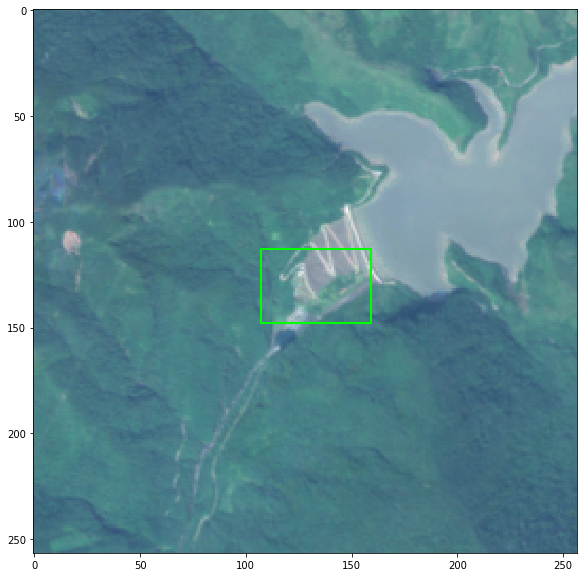

In [84]:
# define a threshold to apply to predictions

for x,y_true in train_dataset.take(1):
    image = x[0,...]

obj_threshold=0.5
boxes = predict_bounding_box(image[np.newaxis,...,0:3], model, obj_threshold, NMS_THRESHOLD, ANCHORS, CLASS)

# batch dimensions is removed, since we do not need it in get_matplotlib_boxes_2
img_shape = image[...,0:3].numpy().shape
# get matplotlib bbox objects
plt_boxes = get_matplotlib_boxes_2(boxes, img_shape)

# visualize result
# in an untrainedd network, all the boxes are in the upper left corner and are very small
# this can be expected, as the results are just bad...

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(image_features[...,0:3])
print(len(plt_boxes))
for plt_box in plt_boxes:
    ax.add_patch(plt_box)
plt.show()